In [13]:
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

In [14]:
import pandas as pd
import requests

def get_imbalance_price(start_date, end_date, price_area="DK1", sort_by="TimeUTC ASC", imbalance_type="afrr"):
    
    COLS_SEL = ['TimeUTC', 'BalancingDemand','SpotPriceEUR','DominatingDirection']
    
    if isinstance(start_date, pd.Timestamp):
        start_date = start_date.strftime("%Y-%m-%dT%H:%M")
    if isinstance(end_date, pd.Timestamp):
        end_date = end_date.strftime("%Y-%m-%dT%H:%M")
    
    base_url = "https://api.energidataservice.dk/dataset/ImbalancePrice"
    
    url = f"{base_url}?offset=0&start={start_date}&end={end_date}&filter={{\"PriceArea\":[\"{price_area}\"]}}&sort={sort_by}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data.get("records", []))
        
        if imbalance_type == "afrr":
            COLS_SEL.extend(['aFRRUpMW', 'aFRRVWAUpEUR', 'aFRRDownMW', 'aFRRVWADownEUR'])
            return df[COLS_SEL].set_index('TimeUTC')
        elif imbalance_type == "mfrr":
            COLS_SEL.append(['mFRRVWAUpEUR', 'mFRRVWADownEUR'])
            return df[[COLS_SEL]].set_index('TimeUTC')
            
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None
    
    
start = pd.Timestamp('20240101', tz='Europe/Copenhagen')
end = pd.Timestamp('20250501', tz='Europe/Copenhagen')
df = get_imbalance_price(start_date=start, end_date=end, price_area="DK1")

In [15]:
import pandas as pd
import numpy as np 
from arch import arch_model

# Your existing code
df['res_aFRRVWAUp'] = df['SpotPriceEUR'] - df['aFRRVWAUpEUR'].rolling(24).mean()
df['res_aFRRVWADown'] = df['SpotPriceEUR'] - df['aFRRVWADownEUR'].rolling(24).mean()

df = df.dropna(subset=['res_aFRRVWAUp', 'res_aFRRVWADown'])


/tmp/ipykernel_39593/4103451447.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scenario_prices_up[s, t] = mean_forecast_up[t] + vol_forecast_up[t] * scenarios_up[s]
/tmp/ipykernel_39593/4103451447.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scenario_prices_down[s, t] = mean_forecast_down[t] + vol_forecast_down[t] * scenarios_down[s]


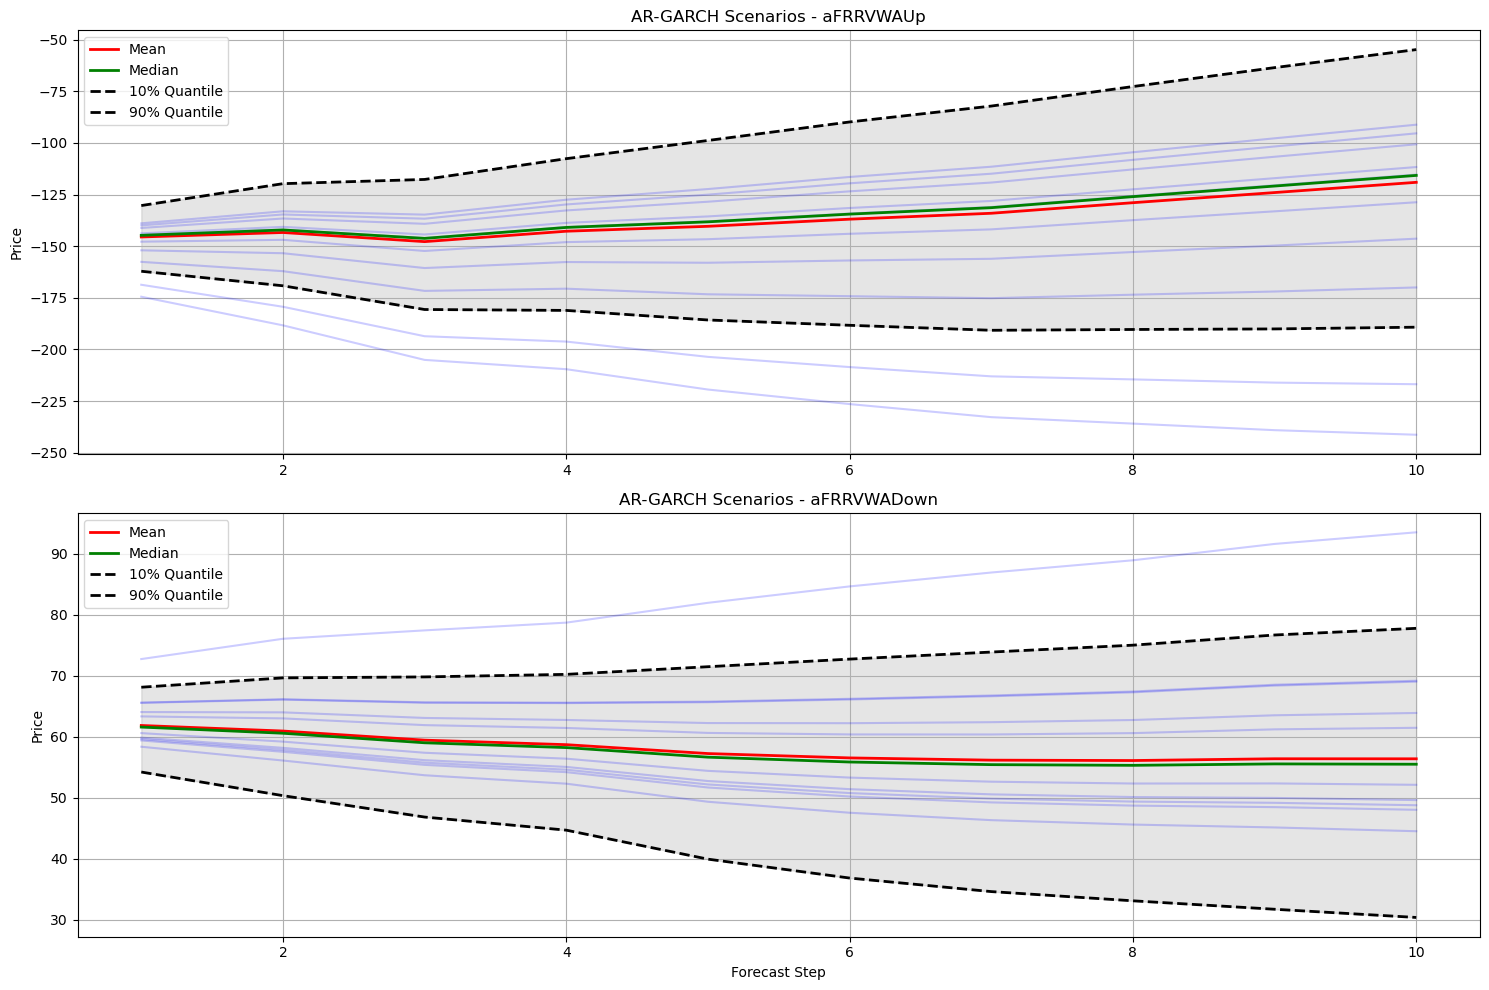

Summary of scenario forecasts:
   step     mean_up   median_up      q10_up      q90_up  mean_down  \
0     1 -145.537989 -144.745659 -162.145063 -130.322040  61.858213   
1     2 -143.370956 -142.139555 -169.180853 -119.723077  60.950648   
2     3 -147.797172 -146.228896 -180.667896 -117.679930  59.455529   
3     4 -142.754701 -140.924882 -181.107300 -107.614783  58.715298   
4     5 -140.377570 -138.213136 -185.743623  -98.811695  57.259050   

   median_down   q10_down   q90_down  
0    61.597583  54.231875  68.130592  
1    60.588711  50.359920  69.661128  
2    59.024836  46.852952  69.820679  
3    58.236516  44.705585  70.237765  
4    56.667662  39.954343  71.491527  


In [16]:
import numpy as np
import pandas as pd
from arch import arch_model
from copulae import GaussianCopula
import matplotlib.pyplot as plt


# ---------------------------------------------------------------------------------
# STEP 0: Calculate the residuals
# ---------------------------------------------------------------------------------
df['res_aFRRVWAUp'] = df['SpotPriceEUR'] - df['aFRRVWAUpEUR'].rolling(24).mean()
df['res_aFRRVWADown'] = df['SpotPriceEUR'] - df['aFRRVWADownEUR'].rolling(24).mean()

df = df.dropna(subset=['res_aFRRVWAUp', 'res_aFRRVWADown'])

# ---------------------------------------------------------------------------------
# STEP 1: Fit AR-GARCH (your existing code)
# ---------------------------------------------------------------------------------
model_up = arch_model(df['res_aFRRVWAUp'], vol='GARCH', p=1, q=1, mean='AR', lags=10)
model_down = arch_model(df['res_aFRRVWADown'], vol='GARCH', p=1, q=1, mean='AR', lags=10)
results_up = model_up.fit(disp='off')
results_down = model_down.fit(disp='off')

# ---------------------------------------------------------------------------------
# STEP 2: Extract residuals + drop NaNs
# ---------------------------------------------------------------------------------
# Get standardized residuals (NaN if conditional vol was 0/invalid)
z_up = results_up.resid / results_up.conditional_volatility
z_down = results_down.resid / results_down.conditional_volatility

# Combine into DataFrame and drop NaNs (aligns both series)
z_clean = pd.DataFrame({'up': z_up, 'down': z_down}).dropna()
z_up_clean = z_clean['up'].values
z_down_clean = z_clean['down'].values
z = z_clean.values  # (n_samples, 2) matrix

# ---------------------------------------------------------------------------------
# STEP 3: Fit Gaussian copula (auto-handles correlation)
# ---------------------------------------------------------------------------------
cop = GaussianCopula(dim=2)
cop.fit(z)  # Works on clean data

# ---------------------------------------------------------------------------------
# STEP 4: Generate scenarios for quantiles [0.1, 0.5, 0.9]
# ---------------------------------------------------------------------------------
n_scenarios = 1000
u = cop.random(n_scenarios)  # Correlated uniforms

# Map to residual quantiles (using cleaned data)
scenarios_up = np.quantile(z_up_clean, u[:, 0])
scenarios_down = np.quantile(z_down_clean, u[:, 1])

# ---------------------------------------------------------------------------------
# STEP 5: Generate multi-step forecast and apply scenarios
# ---------------------------------------------------------------------------------
# Number of steps for the forecast
n_steps = 10  # Adjust this as needed

# Get multi-step forecasts from both models
forecast_up = results_up.forecast(horizon=n_steps)
forecast_down = results_down.forecast(horizon=n_steps)

# Extract the forecasted means and volatilities for all steps
mean_forecast_up = forecast_up.mean.iloc[-1]  # Last row, all columns
vol_forecast_up = np.sqrt(forecast_up.variance.iloc[-1])

mean_forecast_down = forecast_down.mean.iloc[-1]
vol_forecast_down = np.sqrt(forecast_down.variance.iloc[-1])

# Create matrices to store multi-step scenarios
scenario_prices_up = np.zeros((n_scenarios, n_steps))
scenario_prices_down = np.zeros((n_scenarios, n_steps))

# For each scenario and step, apply the correction
for s in range(n_scenarios):
    for t in range(n_steps):
        # Apply: mean + volatility * standardized_residual
        scenario_prices_up[s, t] = mean_forecast_up[t] + vol_forecast_up[t] * scenarios_up[s]
        scenario_prices_down[s, t] = mean_forecast_down[t] + vol_forecast_down[t] * scenarios_down[s]

# ---------------------------------------------------------------------------------
# STEP 6: Calculate scenario statistics
# ---------------------------------------------------------------------------------
# Calculate statistics across scenarios for each time step
mean_price_up = np.mean(scenario_prices_up, axis=0)
median_price_up = np.median(scenario_prices_up, axis=0)
q10_price_up = np.quantile(scenario_prices_up, 0.1, axis=0)
q90_price_up = np.quantile(scenario_prices_up, 0.9, axis=0)

mean_price_down = np.mean(scenario_prices_down, axis=0)
median_price_down = np.median(scenario_prices_down, axis=0)
q10_price_down = np.quantile(scenario_prices_down, 0.1, axis=0)
q90_price_down = np.quantile(scenario_prices_down, 0.9, axis=0)

# ---------------------------------------------------------------------------------
# STEP 7: Visualization
# ---------------------------------------------------------------------------------
# Plot some sample paths
plt.figure(figsize=(15, 10))

# Plot up scenarios
plt.subplot(2, 1, 1)
for i in range(min(10, n_scenarios)):  # Plot first 10 scenarios
    plt.plot(range(1, n_steps + 1), scenario_prices_up[i], 'b-', alpha=0.2)

# Plot statistics
plt.plot(range(1, n_steps + 1), mean_price_up, 'r-', linewidth=2, label='Mean')
plt.plot(range(1, n_steps + 1), median_price_up, 'g-', linewidth=2, label='Median')
plt.plot(range(1, n_steps + 1), q10_price_up, 'k--', linewidth=2, label='10% Quantile')
plt.plot(range(1, n_steps + 1), q90_price_up, 'k--', linewidth=2, label='90% Quantile')
plt.fill_between(range(1, n_steps + 1), q10_price_up, q90_price_up, color='gray', alpha=0.2)

plt.title('AR-GARCH Scenarios - aFRRVWAUp')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

# Plot down scenarios
plt.subplot(2, 1, 2)
for i in range(min(10, n_scenarios)):  # Plot first 10 scenarios
    plt.plot(range(1, n_steps + 1), scenario_prices_down[i], 'b-', alpha=0.2)

# Plot statistics
plt.plot(range(1, n_steps + 1), mean_price_down, 'r-', linewidth=2, label='Mean')
plt.plot(range(1, n_steps + 1), median_price_down, 'g-', linewidth=2, label='Median')
plt.plot(range(1, n_steps + 1), q10_price_down, 'k--', linewidth=2, label='10% Quantile')
plt.plot(range(1, n_steps + 1), q90_price_down, 'k--', linewidth=2, label='90% Quantile')
plt.fill_between(range(1, n_steps + 1), q10_price_down, q90_price_down, color='gray', alpha=0.2)

plt.title('AR-GARCH Scenarios - aFRRVWADown')
plt.xlabel('Forecast Step')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
# STEP 8: Store results in DataFrame for further analysis
# ---------------------------------------------------------------------------------
# Create DataFrame with all scenarios
scenarios_df = pd.DataFrame({
    'step': np.tile(np.arange(1, n_steps + 1), n_scenarios),
    'scenario': np.repeat(np.arange(1, n_scenarios + 1), n_steps),
    'price_up': scenario_prices_up.flatten(),
    'price_down': scenario_prices_down.flatten()
})

# Create DataFrame with summary statistics
summary_df = pd.DataFrame({
    'step': np.arange(1, n_steps + 1),
    'mean_up': mean_price_up,
    'median_up': median_price_up,
    'q10_up': q10_price_up,
    'q90_up': q90_price_up,
    'mean_down': mean_price_down,
    'median_down': median_price_down,
    'q10_down': q10_price_down,
    'q90_down': q90_price_down
})

# Print first few rows of the summary
print("Summary of scenario forecasts:")
print(summary_df.head())

# Return the scenario prices for further analysis
scenario_results = {
    'prices_up': scenario_prices_up,
    'prices_down': scenario_prices_down,
    'summary': summary_df,
    'scenarios_df': scenarios_df
}

In [20]:
import numpy as np
import pandas as pd
from arch import arch_model
from copulae import GaussianCopula

# ---------------------------------------------------------------------------------
# STEP 0: Calculate the residuals
# ---------------------------------------------------------------------------------
df['res_aFRRVWAUp'] = df['SpotPriceEUR'] - df['aFRRVWAUpEUR'].rolling(24).mean()
df['res_aFRRVWADown'] = df['SpotPriceEUR'] - df['aFRRVWADownEUR'].rolling(24).mean()

# Store the rolling means to convert back to real prices later
df['rolling_mean_up'] = df['aFRRVWAUpEUR'].rolling(24).mean()
df['rolling_mean_down'] = df['aFRRVWADownEUR'].rolling(24).mean()

df = df.dropna(subset=['res_aFRRVWAUp', 'res_aFRRVWADown'])

# Get the last rolling means to use for converting residuals back to real prices
last_rolling_mean_up = df['rolling_mean_up'].iloc[-1]
last_rolling_mean_down = df['rolling_mean_down'].iloc[-1]

# ---------------------------------------------------------------------------------
# STEP 1: Fit AR-GARCH
# ---------------------------------------------------------------------------------
model_up = arch_model(df['res_aFRRVWAUp'], vol='GARCH', p=1, q=1, mean='AR', lags=10)
model_down = arch_model(df['res_aFRRVWADown'], vol='GARCH', p=1, q=1, mean='AR', lags=10)
results_up = model_up.fit(disp='off')
results_down = model_down.fit(disp='off')

# ---------------------------------------------------------------------------------
# STEP 2: Extract residuals + drop NaNs
# ---------------------------------------------------------------------------------
z_up = results_up.resid / results_up.conditional_volatility
z_down = results_down.resid / results_down.conditional_volatility

z_clean = pd.DataFrame({'up': z_up, 'down': z_down}).dropna()
z_up_clean = z_clean['up'].values
z_down_clean = z_clean['down'].values
z = z_clean.values

# ---------------------------------------------------------------------------------
# STEP 3: Fit Gaussian copula
# ---------------------------------------------------------------------------------
cop = GaussianCopula(dim=2)
cop.fit(z)

# ---------------------------------------------------------------------------------
# STEP 4: Generate scenarios for simulation
# ---------------------------------------------------------------------------------
n_scenarios = 1000
u = cop.random(n_scenarios)
scenarios_up = np.quantile(z_up_clean, u[:, 0])
scenarios_down = np.quantile(z_down_clean, u[:, 1])

# ---------------------------------------------------------------------------------
# STEP 5: Generate recursive multi-step forecast with scenarios
# ---------------------------------------------------------------------------------
n_steps = 10  # Forecast horizon

# Initialize arrays to store results
scenario_prices_up = np.zeros((n_scenarios, n_steps))
scenario_prices_down = np.zeros((n_scenarios, n_steps))

# Get the last values and parameters needed for forecasting
last_resid_up = results_up.resid.iloc[-10:].values  # Last 10 residuals for AR(10)
last_resid_down = results_down.resid.iloc[-10:].values
last_vol_up = results_up.conditional_volatility.iloc[-1]
last_vol_down = results_down.conditional_volatility.iloc[-1]

# Extract AR and GARCH parameters
ar_params_up = results_up.params[1:11]  # AR parameters (assuming 10 lags)
ar_constant_up = results_up.params[0]   # Constant term
garch_omega_up = results_up.params[11]  # GARCH constant
garch_alpha_up = results_up.params[12]  # ARCH term
garch_beta_up = results_up.params[13]   # GARCH term

ar_params_down = results_down.params[1:11]
ar_constant_down = results_down.params[0]
garch_omega_down = results_down.params[11]
garch_alpha_down = results_down.params[12]
garch_beta_down = results_down.params[13]

# Recursive forecasting for each scenario
for s in range(n_scenarios):
    # Initialize with the last observed values
    curr_resid_up = last_resid_up.copy()
    curr_resid_down = last_resid_down.copy()
    curr_vol_up = last_vol_up
    curr_vol_down = last_vol_down
    
    for t in range(n_steps):
        # 1. Compute mean forecast using AR model
        mean_up = ar_constant_up + np.sum(ar_params_up * curr_resid_up[::-1])
        mean_down = ar_constant_down + np.sum(ar_params_down * curr_resid_down[::-1])
        
        # 2. Update volatility using GARCH recursion
        curr_vol_up = np.sqrt(garch_omega_up + 
                             garch_alpha_up * curr_resid_up[-1]**2 + 
                             garch_beta_up * curr_vol_up**2)
        curr_vol_down = np.sqrt(garch_omega_down + 
                               garch_alpha_down * curr_resid_down[-1]**2 + 
                               garch_beta_down * curr_vol_down**2)
        
        # 3. Apply shock from copula scenarios
        shock_up = scenarios_up[s] * curr_vol_up
        shock_down = scenarios_down[s] * curr_vol_down
        
        # 4. Calculate residual for this step
        curr_step_resid_up = mean_up + shock_up
        curr_step_resid_down = mean_down + shock_down
        
        # 5. Store the forecasted residual value
        scenario_prices_up[s, t] = curr_step_resid_up
        scenario_prices_down[s, t] = curr_step_resid_down
        
        # 6. Update the historical values for next step prediction
        curr_resid_up = np.roll(curr_resid_up, 1)
        curr_resid_up[0] = curr_step_resid_up
        curr_resid_down = np.roll(curr_resid_down, 1)
        curr_resid_down[0] = curr_step_resid_down

# ---------------------------------------------------------------------------------
# STEP 6: Convert residuals back to real prices
# ---------------------------------------------------------------------------------
# Add back the rolling mean to get actual price predictions
real_prices_up = scenario_prices_up + last_r

/tmp/ipykernel_39593/653318125.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_constant_up = results_up.params[0]   # Constant term
/tmp/ipykernel_39593/653318125.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_omega_up = results_up.params[11]  # GARCH constant
/tmp/ipykernel_39593/653318125.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_alpha_up = results_up.params[12]  # ARCH term
/tmp/ipykernel_3959

NameError: name 'last_r' is not defined

In [21]:
import numpy as np
import pandas as pd
from arch import arch_model
from copulae import GaussianCopula

# ---------------------------------------------------------------------------------
# STEP 0: Calculate the residuals
# ---------------------------------------------------------------------------------
df['res_aFRRVWAUp'] = df['SpotPriceEUR'] - df['aFRRVWAUpEUR'].rolling(24).mean()
df['res_aFRRVWADown'] = df['SpotPriceEUR'] - df['aFRRVWADownEUR'].rolling(24).mean()

# Store the rolling means to convert back to real prices later
df['rolling_mean_up'] = df['aFRRVWAUpEUR'].rolling(24).mean()
df['rolling_mean_down'] = df['aFRRVWADownEUR'].rolling(24).mean()

df = df.dropna(subset=['res_aFRRVWAUp', 'res_aFRRVWADown'])

# Get the last rolling means to use for converting residuals back to real prices
last_rolling_mean_up = df['rolling_mean_up'].iloc[-1]
last_rolling_mean_down = df['rolling_mean_down'].iloc[-1]

# ---------------------------------------------------------------------------------
# STEP 1: Fit AR-GARCH
# ---------------------------------------------------------------------------------
model_up = arch_model(df['res_aFRRVWAUp'], vol='GARCH', p=1, q=1, mean='AR', lags=10)
model_down = arch_model(df['res_aFRRVWADown'], vol='GARCH', p=1, q=1, mean='AR', lags=10)
results_up = model_up.fit(disp='off')
results_down = model_down.fit(disp='off')

# ---------------------------------------------------------------------------------
# STEP 2: Extract residuals + drop NaNs
# ---------------------------------------------------------------------------------
z_up = results_up.resid / results_up.conditional_volatility
z_down = results_down.resid / results_down.conditional_volatility

z_clean = pd.DataFrame({'up': z_up, 'down': z_down}).dropna()
z_up_clean = z_clean['up'].values
z_down_clean = z_clean['down'].values
z = z_clean.values

# ---------------------------------------------------------------------------------
# STEP 3: Fit Gaussian copula
# ---------------------------------------------------------------------------------
cop = GaussianCopula(dim=2)
cop.fit(z)

# ---------------------------------------------------------------------------------
# STEP 4: Generate scenarios for simulation
# ---------------------------------------------------------------------------------
n_scenarios = 1000
u = cop.random(n_scenarios)
scenarios_up = np.quantile(z_up_clean, u[:, 0])
scenarios_down = np.quantile(z_down_clean, u[:, 1])

# ---------------------------------------------------------------------------------
# STEP 5: Generate recursive multi-step forecast with scenarios
# ---------------------------------------------------------------------------------
n_steps = 10  # Forecast horizon

# Initialize arrays to store results
scenario_prices_up = np.zeros((n_scenarios, n_steps))
scenario_prices_down = np.zeros((n_scenarios, n_steps))

# Get the last values and parameters needed for forecasting
last_resid_up = results_up.resid.iloc[-10:].values  # Last 10 residuals for AR(10)
last_resid_down = results_down.resid.iloc[-10:].values
last_vol_up = results_up.conditional_volatility.iloc[-1]
last_vol_down = results_down.conditional_volatility.iloc[-1]

# Extract AR and GARCH parameters
ar_params_up = results_up.params[1:11]  # AR parameters (assuming 10 lags)
ar_constant_up = results_up.params[0]   # Constant term
garch_omega_up = results_up.params[11]  # GARCH constant
garch_alpha_up = results_up.params[12]  # ARCH term
garch_beta_up = results_up.params[13]   # GARCH term

ar_params_down = results_down.params[1:11]
ar_constant_down = results_down.params[0]
garch_omega_down = results_down.params[11]
garch_alpha_down = results_down.params[12]
garch_beta_down = results_down.params[13]

# Recursive forecasting for each scenario
for s in range(n_scenarios):
    # Initialize with the last observed values
    curr_resid_up = last_resid_up.copy()
    curr_resid_down = last_resid_down.copy()
    curr_vol_up = last_vol_up
    curr_vol_down = last_vol_down
    
    for t in range(n_steps):
        # 1. Compute mean forecast using AR model
        mean_up = ar_constant_up + np.sum(ar_params_up * curr_resid_up[::-1])
        mean_down = ar_constant_down + np.sum(ar_params_down * curr_resid_down[::-1])
        
        # 2. Update volatility using GARCH recursion
        curr_vol_up = np.sqrt(garch_omega_up + 
                             garch_alpha_up * curr_resid_up[-1]**2 + 
                             garch_beta_up * curr_vol_up**2)
        curr_vol_down = np.sqrt(garch_omega_down + 
                               garch_alpha_down * curr_resid_down[-1]**2 + 
                               garch_beta_down * curr_vol_down**2)
        
        # 3. Apply shock from copula scenarios
        shock_up = scenarios_up[s] * curr_vol_up
        shock_down = scenarios_down[s] * curr_vol_down
        
        # 4. Calculate residual for this step
        curr_step_resid_up = mean_up + shock_up
        curr_step_resid_down = mean_down + shock_down
        
        # 5. Store the forecasted residual value
        scenario_prices_up[s, t] = curr_step_resid_up
        scenario_prices_down[s, t] = curr_step_resid_down
        
        # 6. Update the historical values for next step prediction
        curr_resid_up = np.roll(curr_resid_up, 1)
        curr_resid_up[0] = curr_step_resid_up
        curr_resid_down = np.roll(curr_resid_down, 1)
        curr_resid_down[0] = curr_step_resid_down

# ---------------------------------------------------------------------------------
# STEP 6: Convert residuals back to real prices
# ---------------------------------------------------------------------------------
# Add back the rolling mean to get actual price predictions
real_prices_up = scenario_prices_up + last_rolling_mean_up
real_prices_down = scenario_prices_down + last_rolling_mean_down

# ---------------------------------------------------------------------------------
# STEP 7: Create dataframe with scenarios as columns
# ---------------------------------------------------------------------------------
# Create column names for the scenarios
scenario_cols_up = [f'scenario_{i+1}_up' for i in range(n_scenarios)]
scenario_cols_down = [f'scenario_{i+1}_down' for i in range(n_scenarios)]

# Initialize dataframes with steps as index
results_df_up = pd.DataFrame(index=range(1, n_steps+1))
results_df_down = pd.DataFrame(index=range(1, n_steps+1))

# Add each scenario as a column
for i in range(n_scenarios):
    results_df_up[f'scenario_{i+1}'] = real_prices_up[i, :]
    results_df_down[f'scenario_{i+1}'] = real_prices_down[i, :]

# Reset index and rename it
results_df_up = results_df_up.reset_index().rename(columns={'index': 'forecast_step'})
results_df_down = results_df_down.reset_index().rename(columns={'index': 'forecast_step'})

# ---------------------------------------------------------------------------------
# STEP 8: Calculate and add summary statistics
# ---------------------------------------------------------------------------------
# Calculate statistics for up prices
results_df_up['mean'] = np.mean(real_prices_up, axis=0)
results_df_up['median'] = np.median(real_prices_up, axis=0)
results_df_up['q10'] = np.quantile(real_prices_up, 0.1, axis=0)
results_df_up['q90'] = np.quantile(real_prices_up, 0.9, axis=0)

# Calculate statistics for down prices
results_df_down['mean'] = np.mean(real_prices_down, axis=0)
results_df_down['median'] = np.median(real_prices_down, axis=0)
results_df_down['q10'] = np.quantile(real_prices_down, 0.1, axis=0)
results_df_down['q90'] = np.quantile(real_prices_down, 0.9, axis=0)

# Optionally, create a combined dataframe for summary statistics
summary_df = pd.DataFrame({
    'step': range(1, n_steps+1),
    'mean_up': results_df_up['mean'],
    'median_up': results_df_up['median'],
    'q10_up': results_df_up['q10'],
    'q90_up': results_df_up['q90'],
    'mean_down': results_df_down['mean'],
    'median_down': results_df_down['median'],
    'q10_down': results_df_down['q10'],
    'q90_down': results_df_down['q90']
})

# Print first few rows of the results
print("Summary of real price forecasts:")
print(summary_df.head())

# Return the scenario results for further analysis
scenario_results = {
    'up_prices': results_df_up,
    'down_prices': results_df_down,
    'summary': summary_df
}

/tmp/ipykernel_39593/324723140.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_constant_up = results_up.params[0]   # Constant term
/tmp/ipykernel_39593/324723140.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_omega_up = results_up.params[11]  # GARCH constant
/tmp/ipykernel_39593/324723140.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_alpha_up = results_up.params[12]  # ARCH term
/tmp/ipykernel_3959

Summary of real price forecasts:
   step     mean_up   median_up      q10_up      q90_up  mean_down  \
0     1  244.067279  245.912201  224.110641  259.223672  33.704787   
1     2  229.869042  231.647086  210.635811  244.476030  38.430272   
2     3  232.335354  234.132891  212.891272  247.102477  50.811058   
3     4  230.561968  232.232780  212.488681  244.288019  25.370963   
4     5  254.624172  256.318996  236.291146  268.547486  51.613464   

   median_down   q10_down   q90_down  
0    33.811463  26.178308  40.964628  
1    38.525184  31.733781  44.889529  
2    50.922647  42.937884  58.405311  
3    25.455995  19.371555  31.157831  
4    51.704201  45.211520  57.788607  


In [22]:
results_df_down

,forecast_step,scenario_1,scenario_2,scenario_3,scenario_4,scenario_5,scenario_6,scenario_7,scenario_8,scenario_9,...,scenario_995,scenario_996,scenario_997,scenario_998,scenario_999,scenario_1000,mean,median,q10,q90
0,1,35.019479,33.996045,35.420250,39.668832,34.818044,38.372131,31.316324,61.911661,33.170264,...,34.151976,29.434067,35.164111,25.566948,40.034788,36.994247,33.704787,33.811463,26.178308,40.964628
1,2,39.599985,38.689411,39.956561,43.736627,39.420763,42.582921,36.305199,63.526612,37.954693,...,38.828147,34.630509,39.728668,31.189839,44.062227,41.356984,38.430272,38.525184,31.733781,44.889529
2,3,52.186308,51.115731,52.605540,57.049826,51.975594,55.693395,48.312574,80.317233,50.251912,...,51.278846,46.343614,52.337603,42.298363,57.432639,54.252041,50.811058,50.922647,42.937884,58.405311
3,4,26.418912,25.603126,26.738369,30.124943,26.258347,29.091334,23.467103,47.854851,24.944890,...,25.727420,21.966743,26.534199,18.884236,30.416648,27.993013,25.370963,25.455995,19.371555,31.157831
4,5,52.731726,51.861204,53.072618,56.686417,52.560388,55.583457,49.581862,75.605932,51.158803,...,51.993838,47.980834,52.854749,44.691504,56.997695,54.411443,51.613464,51.704201,45.211520,57.788607
5,6,34.955660,34.138787,35.275542,38.666624,34.794881,37.631639,31.999921,56.420136,33.479676,...,34.263247,30.497563,35.071101,27.410953,38.958718,36.531856,33.906315,33.991461,27.898921,39.700887
6,7,37.214207,36.968931,37.310256,38.328472,37.165931,38.017704,36.326708,43.659193,36.771024,...,37.006301,35.875606,37.248870,34.948812,38.416177,37.687480,36.899128,36.924694,35.095330,38.639023
7,8,44.791233,43.777248,45.188303,49.397658,44.591657,48.112929,41.122270,71.435113,42.959092,...,43.931740,39.257392,44.934530,35.425980,49.760234,46.747767,43.488680,43.594371,36.031695,50.681489
8,9,30.372064,29.732258,30.622609,33.278636,30.246136,32.467996,28.057014,47.183879,29.216016,...,29.829740,26.880309,30.462482,24.462756,33.507416,31.606603,29.550177,29.616866,24.844951,34.088711
9,10,58.652661,57.565467,59.078401,63.591672,58.438677,62.214186,54.718799,87.220240,56.688239,...,57.731113,52.719276,58.806305,48.611234,63.980427,60.750459,57.256064,57.369386,49.260682,64.968197


In [24]:
import numpy as np
import pandas as pd
from arch import arch_model
from copulae import GaussianCopula

# ---------------------------------------------------------------------------------
# STEP 0: Calculate the residuals
# ---------------------------------------------------------------------------------
df['res_aFRRVWAUp'] = df['SpotPriceEUR'] - df['aFRRVWAUpEUR']
df['res_aFRRVWADown'] = df['SpotPriceEUR'] - df['aFRRVWADownEUR']

df = df.dropna(subset=['res_aFRRVWAUp', 'res_aFRRVWADown'])

# Store last actual values for reference
last_up_price = df['aFRRVWAUpEUR'].iloc[-1]
last_down_price = df['aFRRVWADownEUR'].iloc[-1]
last_spot_price = df['SpotPriceEUR'].iloc[-1]

# ---------------------------------------------------------------------------------
# STEP 1: Fit AR-GARCH
# ---------------------------------------------------------------------------------
model_up = arch_model(df['res_aFRRVWAUp'], vol='GARCH', p=1, q=1, mean='AR', lags=10)
model_down = arch_model(df['res_aFRRVWADown'], vol='GARCH', p=1, q=1, mean='AR', lags=10)
results_up = model_up.fit(disp='off')
results_down = model_down.fit(disp='off')

# ---------------------------------------------------------------------------------
# STEP 2: Extract residuals + drop NaNs
# ---------------------------------------------------------------------------------
z_up = results_up.resid / results_up.conditional_volatility
z_down = results_down.resid / results_down.conditional_volatility

z_clean = pd.DataFrame({'up': z_up, 'down': z_down}).dropna()
z_up_clean = z_clean['up'].values
z_down_clean = z_clean['down'].values
z = z_clean.values

# ---------------------------------------------------------------------------------
# STEP 3: Fit Gaussian copula
# ---------------------------------------------------------------------------------
cop = GaussianCopula(dim=2)
cop.fit(z)

# ---------------------------------------------------------------------------------
# STEP 4: Generate scenarios for simulation
# ---------------------------------------------------------------------------------
n_scenarios = 1000
u = cop.random(n_scenarios)
scenarios_up = np.quantile(z_up_clean, u[:, 0])
scenarios_down = np.quantile(z_down_clean, u[:, 1])

# ---------------------------------------------------------------------------------
# STEP 5: Generate recursive multi-step forecast with scenarios
# ---------------------------------------------------------------------------------
n_steps = 10  # Forecast horizon

# Initialize arrays to store results
scenario_residuals_up = np.zeros((n_scenarios, n_steps))
scenario_residuals_down = np.zeros((n_scenarios, n_steps))

# Get the last values and parameters needed for forecasting
last_resid_up = results_up.resid.iloc[-10:].values  # Last 10 residuals for AR(10)
last_resid_down = results_down.resid.iloc[-10:].values
last_vol_up = results_up.conditional_volatility.iloc[-1]
last_vol_down = results_down.conditional_volatility.iloc[-1]

# Extract AR and GARCH parameters
ar_params_up = results_up.params[1:11]  # AR parameters (assuming 10 lags)
ar_constant_up = results_up.params[0]   # Constant term
garch_omega_up = results_up.params[11]  # GARCH constant
garch_alpha_up = results_up.params[12]  # ARCH term
garch_beta_up = results_up.params[13]   # GARCH term

ar_params_down = results_down.params[1:11]
ar_constant_down = results_down.params[0]
garch_omega_down = results_down.params[11]
garch_alpha_down = results_down.params[12]
garch_beta_down = results_down.params[13]

# Recursive forecasting for each scenario
for s in range(n_scenarios):
    # Initialize with the last observed values
    curr_resid_up = last_resid_up.copy()
    curr_resid_down = last_resid_down.copy()
    curr_vol_up = last_vol_up
    curr_vol_down = last_vol_down
    
    for t in range(n_steps):
        # 1. Compute mean forecast using AR model
        mean_up = ar_constant_up + np.sum(ar_params_up * curr_resid_up[::-1])
        mean_down = ar_constant_down + np.sum(ar_params_down * curr_resid_down[::-1])
        
        # 2. Update volatility using GARCH recursion
        curr_vol_up = np.sqrt(garch_omega_up + 
                             garch_alpha_up * curr_resid_up[-1]**2 + 
                             garch_beta_up * curr_vol_up**2)
        curr_vol_down = np.sqrt(garch_omega_down + 
                               garch_alpha_down * curr_resid_down[-1]**2 + 
                               garch_beta_down * curr_vol_down**2)
        
        # 3. Apply shock from copula scenarios
        shock_up = scenarios_up[s] * curr_vol_up
        shock_down = scenarios_down[s] * curr_vol_down
        
        # 4. Calculate residual for this step
        curr_step_resid_up = mean_up + shock_up
        curr_step_resid_down = mean_down + shock_down
        
        # 5. Store the forecasted residual value
        scenario_residuals_up[s, t] = curr_step_resid_up
        scenario_residuals_down[s, t] = curr_step_resid_down
        
        # 6. Update the historical values for next step prediction
        curr_resid_up = np.roll(curr_resid_up, 1)
        curr_resid_up[0] = curr_step_resid_up
        curr_resid_down = np.roll(curr_resid_down, 1)
        curr_resid_down[0] = curr_step_resid_down

# ---------------------------------------------------------------------------------
# STEP 6: Convert residuals to real prices based on relationship with spot price
# ---------------------------------------------------------------------------------
# Convert from residuals to actual aFRR prices
# The residual is: SpotPrice - aFRRPrice, so aFRRPrice = SpotPrice - residual
# We need to forecast the spot price first (assume simple random walk for simplicity)
spot_forecast = np.full(n_steps, last_spot_price)  # Simple assumption that spot price stays constant

# Calculate actual aFRR prices for each scenario by inverting the residual relationship
scenario_prices_up = np.zeros_like(scenario_residuals_up)
scenario_prices_down = np.zeros_like(scenario_residuals_down)

for s in range(n_scenarios):
    for t in range(n_steps):
        # Convert residuals to actual prices: aFRRPrice = SpotPrice - residual
        scenario_prices_up[s, t] = spot_forecast[t] - scenario_residuals_up[s, t]
        scenario_prices_down[s, t] = spot_forecast[t] - scenario_residuals_down[s, t]

# ---------------------------------------------------------------------------------
# STEP 7: Create a single dataframe with desired quantiles
# ---------------------------------------------------------------------------------
# Calculate quantiles for up/down prices
q10_prices_up = np.quantile(scenario_prices_up, 0.10, axis=0)
q95_prices_up = np.quantile(scenario_prices_up, 0.95, axis=0)
q10_prices_down = np.quantile(scenario_prices_down, 0.10, axis=0)
q95_prices_down = np.quantile(scenario_prices_down, 0.95, axis=0)

# Create the single results dataframe
final_results_df = pd.DataFrame({
    'forecast_step': range(1, n_steps+1),
    'q10_up_EUR': q10_prices_up,
    'q95_up_EUR': q95_prices_up,
    'q10_down_EUR': q10_prices_down,
    'q95_down_EUR': q95_prices_down
})

# Add scenario columns for all scenarios
for i in range(n_scenarios):
    final_results_df[f'scenario_{i+1}_up_EUR'] = scenario_prices_up[i, :]
    final_results_df[f'scenario_{i+1}_down_EUR'] = scenario_prices_down[i, :]

# Print first few rows of the results
print("Final results dataframe with real prices:")
print(final_results_df[['forecast_step', 'q10_up_EUR', 'q95_up_EUR', 'q10_down_EUR', 'q95_down_EUR']].head())



/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.784e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.185e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/tmp/ipykernel_39593/2627706880.py

Final results dataframe with real prices:
   forecast_step  q10_up_EUR   q95_up_EUR  q10_down_EUR  q95_down_EUR
0              1 -171.240606   709.065462      9.122816     78.425076
1              2  -16.676482  1121.812130     12.926584     75.481522
2              3  -51.191869   676.583915    -13.378577     64.473641
3              4   -0.890035   514.832361     16.959748     64.507049
4              5  -74.655770   507.113918      2.050106     47.850389


/tmp/ipykernel_39593/2627706880.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_results_df[f'scenario_{i+1}_up_EUR'] = scenario_prices_up[i, :]
/tmp/ipykernel_39593/2627706880.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_results_df[f'scenario_{i+1}_down_EUR'] = scenario_prices_down[i, :]
/tmp/ipykernel_39593/2627706880.py:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

In [26]:
final_results_df.columns

Index(['forecast_step', 'q10_up_EUR', 'q95_up_EUR', 'q10_down_EUR',
       'q95_down_EUR', 'scenario_1_up_EUR', 'scenario_1_down_EUR',
       'scenario_2_up_EUR', 'scenario_2_down_EUR', 'scenario_3_up_EUR',
       ...
       'scenario_996_up_EUR', 'scenario_996_down_EUR', 'scenario_997_up_EUR',
       'scenario_997_down_EUR', 'scenario_998_up_EUR', 'scenario_998_down_EUR',
       'scenario_999_up_EUR', 'scenario_999_down_EUR', 'scenario_1000_up_EUR',
       'scenario_1000_down_EUR'],
      dtype='object', length=2005)

/tmp/ipykernel_39593/3429872693.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_constant_up = results_up.params[0]
/tmp/ipykernel_39593/3429872693.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_omega_up = results_up.params[11]
/tmp/ipykernel_39593/3429872693.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_alpha_up = results_up.params[12]
/tmp/ipykernel_39593/3429872693.py:84: FutureWarning: Series.__ge

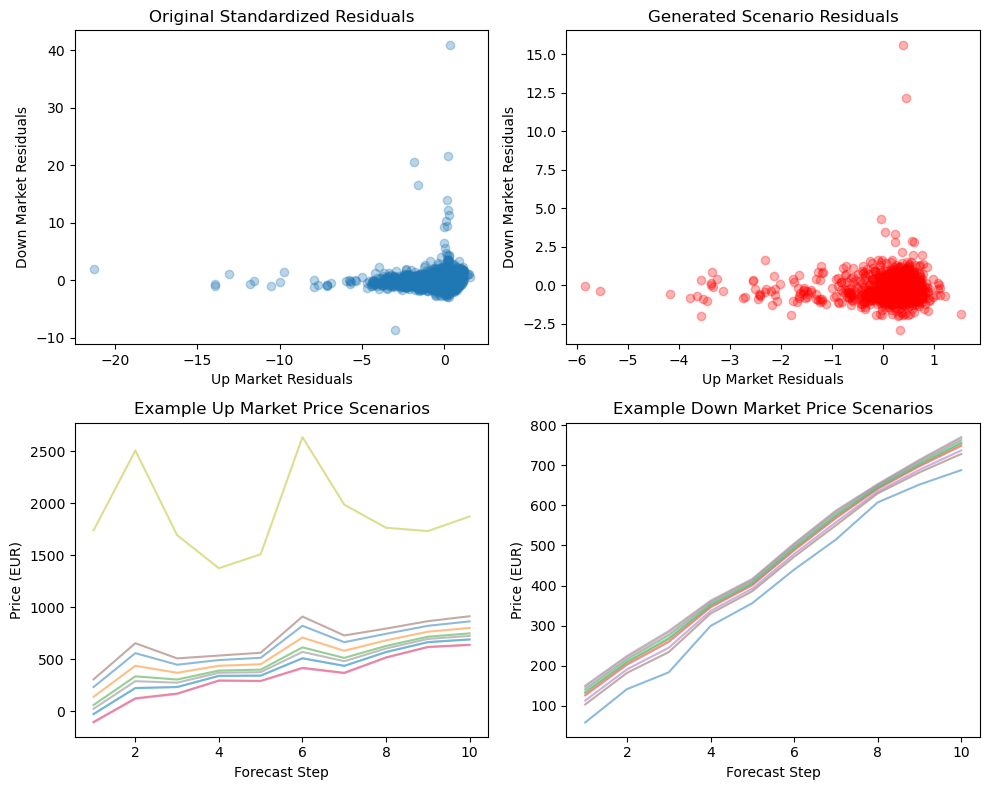

In [29]:
import numpy as np
import pandas as pd
from arch import arch_model
from copulae import GaussianCopula
from scipy.stats import norm
import matplotlib.pyplot as plt

# Assume steps 0-2 are already executed as in your code
# (AR-GARCH models fitted and standardized residuals extracted)

# ---------------------------------------------------------------------------------
# STEP 3: Fit Copula - UPDATED with more options from Patton's paper
# ---------------------------------------------------------------------------------
# Based on page 926 of Patton's paper, we can choose from various copula models
# Here we'll implement both Gaussian and t copula as options

from copulae import GaussianCopula, StudentCopula

# Option to select copula type
copula_type = "t"  # Options: "gaussian" or "t"

if copula_type == "gaussian":
    # Gaussian copula (page 926)
    cop = GaussianCopula(dim=2)
    cop.fit(z)
else:
    # Student's t copula (page 926) - captures tail dependence better
    cop = StudentCopula(dim=2)
    cop.fit(z)

# ---------------------------------------------------------------------------------
# STEP 4: Generate scenarios using probability integral transform
# ---------------------------------------------------------------------------------
# Following pages 902-903 and 947-949 of Patton's paper

n_scenarios = 1000

# Generate random samples from the fitted copula
u = cop.random(n_scenarios)  # This gives uniform [0,1] variates with the copula dependence

# Transform to standardized residuals using inverse CDF/quantile function
# Using the empirical distribution function (EDF) approach from page 906
scenarios_up = np.quantile(z_up_clean, u[:, 0])
scenarios_down = np.quantile(z_down_clean, u[:, 1])

# Visualize the generated scenarios to verify the dependence structure
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.scatter(z_up_clean, z_down_clean, alpha=0.3)
plt.title('Original Standardized Residuals')
plt.xlabel('Up Market Residuals')
plt.ylabel('Down Market Residuals')

plt.subplot(2, 2, 2)
plt.scatter(scenarios_up, scenarios_down, alpha=0.3, color='red')
plt.title('Generated Scenario Residuals')
plt.xlabel('Up Market Residuals')
plt.ylabel('Down Market Residuals')

# ---------------------------------------------------------------------------------
# STEP 5: Generate multi-step forecasts with scenarios
# ---------------------------------------------------------------------------------
# Following the approach on pages 947-949 for simulation

n_steps = 10  # Forecast horizon

# Arrays to store the results
scenario_residuals_up = np.zeros((n_scenarios, n_steps))
scenario_residuals_down = np.zeros((n_scenarios, n_steps))
scenario_vols_up = np.zeros((n_scenarios, n_steps))
scenario_vols_down = np.zeros((n_scenarios, n_steps))

# Get the last values and parameters for forecasting
last_resid_up = results_up.resid.iloc[-10:].values
last_resid_down = results_down.resid.iloc[-10:].values
last_vol_up = results_up.conditional_volatility.iloc[-1]
last_vol_down = results_down.conditional_volatility.iloc[-1]

# Extract model parameters
ar_params_up = results_up.params[1:11]
ar_constant_up = results_up.params[0]
garch_omega_up = results_up.params[11]
garch_alpha_up = results_up.params[12]
garch_beta_up = results_up.params[13]

ar_params_down = results_down.params[1:11]
ar_constant_down = results_down.params[0]
garch_omega_down = results_down.params[11]
garch_alpha_down = results_down.params[12]
garch_beta_down = results_down.params[13]

# We'll generate a different set of innovations for each time step
# as described on page 947-948 of Patton's paper
for s in range(n_scenarios):
    # Initialize with the last observed values
    curr_resid_up = last_resid_up.copy()
    curr_resid_down = last_resid_down.copy()
    curr_vol_up = last_vol_up
    curr_vol_down = last_vol_down
    
    for t in range(n_steps):
        # 1. Compute conditional mean forecast using AR model
        mean_up = ar_constant_up + np.sum(ar_params_up * curr_resid_up[::-1])
        mean_down = ar_constant_down + np.sum(ar_params_down * curr_resid_down[::-1])
        
        # 2. Update volatility using GARCH recursion
        curr_vol_up = np.sqrt(garch_omega_up + 
                             garch_alpha_up * curr_resid_up[-1]**2 + 
                             garch_beta_up * curr_vol_up**2)
        curr_vol_down = np.sqrt(garch_omega_down + 
                               garch_alpha_down * curr_resid_down[-1]**2 + 
                               garch_beta_down * curr_vol_down**2)
        
        # Store the volatility forecasts
        scenario_vols_up[s, t] = curr_vol_up
        scenario_vols_down[s, t] = curr_vol_down
        
        # 3. Apply shock from copula scenarios
        # Using the standardized residuals from the copula (page 948)
        # For each scenario we use the same innovation for all time steps
        # This preserves the dependence structure across the entire path
        shock_up = scenarios_up[s] * curr_vol_up
        shock_down = scenarios_down[s] * curr_vol_down
        
        # 4. Calculate residual for this step
        curr_step_resid_up = mean_up + shock_up
        curr_step_resid_down = mean_down + shock_down
        
        # 5. Store the forecasted residual value
        scenario_residuals_up[s, t] = curr_step_resid_up
        scenario_residuals_down[s, t] = curr_step_resid_down
        
        # 6. Update the historical values for next step prediction
        curr_resid_up = np.roll(curr_resid_up, 1)
        curr_resid_up[0] = curr_step_resid_up
        curr_resid_down = np.roll(curr_resid_down, 1)
        curr_resid_down[0] = curr_step_resid_down

# ---------------------------------------------------------------------------------
# STEP 6: Convert residuals to real prices
# ---------------------------------------------------------------------------------
# As described on page 948-949, we need to convert from standardized residuals to actual values

# For spot price forecasting, we can use a more sophisticated approach
# Here we'll use a simple AR(1) model for demonstration
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(1) model to spot prices
spot_model = ARIMA(df['SpotPriceEUR'].dropna(), order=(1, 0, 0))
spot_results = spot_model.fit()

# Generate spot price forecast
last_spot = df['SpotPriceEUR'].iloc[-1]
spot_forecast = np.zeros(n_steps)
spot_ar_coef = spot_results.params[1]
spot_const = spot_results.params[0]

spot_forecast[0] = spot_const + spot_ar_coef * last_spot
for t in range(1, n_steps):
    spot_forecast[t] = spot_const + spot_ar_coef * spot_forecast[t-1]

# Calculate actual aFRR prices for each scenario by inverting the residual relationship
scenario_prices_up = np.zeros_like(scenario_residuals_up)
scenario_prices_down = np.zeros_like(scenario_residuals_down)

for s in range(n_scenarios):
    for t in range(n_steps):
        # Convert residuals to actual prices: aFRRPrice = SpotPrice - residual
        scenario_prices_up[s, t] = spot_forecast[t] - scenario_residuals_up[s, t]
        scenario_prices_down[s, t] = spot_forecast[t] - scenario_residuals_down[s, t]

# Plot some example scenarios (first 10)
plt.subplot(2, 2, 3)
for s in range(10):
    plt.plot(range(1, n_steps+1), scenario_prices_up[s], alpha=0.5)
plt.title('Example Up Market Price Scenarios')
plt.xlabel('Forecast Step')
plt.ylabel('Price (EUR)')

plt.subplot(2, 2, 4)
for s in range(10):
    plt.plot(range(1, n_steps+1), scenario_prices_down[s], alpha=0.5)
plt.title('Example Down Market Price Scenarios')
plt.xlabel('Forecast Step')
plt.ylabel('Price (EUR)')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
# STEP 7: Calculate risk measures as described on page 947
# ---------------------------------------------------------------------------------
# Calculate quantiles for prices (VaR at different confidence levels)
q_levels = [0.01, 0.05, 0.10, 0.50, 0.90, 0.95, 0.99]
q_names = ['q01', 'q05', 'q10', 'q50', 'q90', 'q95', 'q99']

result_columns = ['forecast_step']
for q_name in q_names:
    result_columns.extend([f'{q_name}_up_EUR', f'{q_name}_down_EUR'])

final_results_df = pd.DataFrame(columns=result_columns)
final_results_df['forecast_step'] = range(1, n_steps+1)

for i, q in enumerate(q_levels):
    q_name = q_names[i]
    final_results_df[f'{q_name}_up_EUR'] = np.quantile(scenario_prices_up, q, axis=0)
    final_results_df[f'{q_name}_down_EUR'] = np.quantile(scenario_prices_down, q, axis=0)

# Calculate Expected Shortfall (ES) for the 5% tail as described on page 947
# ES is the expected value given that the value is below the q05 VaR
es05_up = np.zeros(n_steps)
es05_down = np.zeros(n_steps)

for t in range(n_steps):
    q05_up = final_results_df.loc[t, 'q05_up_EUR']
    q05_down = final_results_df.loc[t, 'q05_down_EUR']
    
    # Filter scenarios that are below the 5% VaR
    tail_scenarios_up = scenario_prices_up[:, t][scenario_prices_up[:, t] <= q05_up]
    tail_scenarios_down = scenario_prices_down[:, t][scenario_prices_down[:, t] <= q05_down]
    
    # Calculate ES as the mean of these tail scenarios
    es05_up[t] = np.mean(tail_scenarios_up)
    es05_down[t] = np.mean(tail_scenarios_down)

final_results_df['es05_up_EUR'] = es05_up
final_results_df['es05_down_EUR'] = es05_down

# Add scenario columns for all scenarios (optional)
if n_scenarios <= 100:  # Only add individual scenarios if there aren't too many
    for i in range(n_scenarios):
        final_results_df[f'scenario_{i+1}_up_EUR'] = scenario_prices_up[i, :]
        final_results_df[f'scenario_{i+1}_down_EUR'] = scenario_prices_down[i, :]



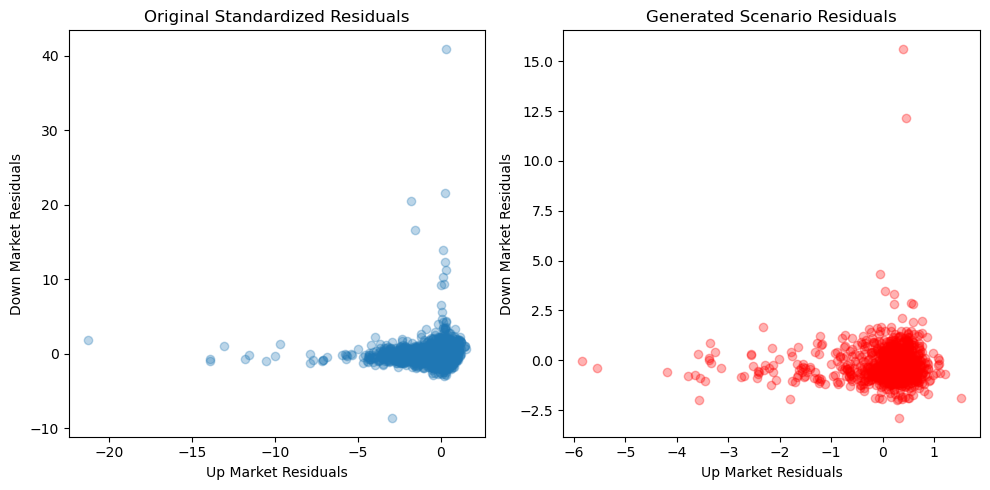

In [32]:
# Transform uniform variables to standardized residuals using the empirical distribution
# This follows the approach on page 906 (using the empirical distribution function)
scenarios_up = np.quantile(z_up_clean, u[:, 0])
scenarios_down = np.quantile(z_down_clean, u[:, 1])

# Optional: Visualize the generated scenarios
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(z_up_clean, z_down_clean, alpha=0.3)
plt.title('Original Standardized Residuals')
plt.xlabel('Up Market Residuals')
plt.ylabel('Down Market Residuals')

plt.subplot(1, 2, 2)
plt.scatter(scenarios_up, scenarios_down, alpha=0.3, color='red')
plt.title('Generated Scenario Residuals')
plt.xlabel('Up Market Residuals')
plt.ylabel('Down Market Residuals')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from copulae import GaussianCopula, StudentCopula

def generate_copula_scenarios(garch_results_list, standardized_residuals_list, 
                             n_scenarios=1000, n_steps=10, 
                             copula_type="gaussian", 
                             quantiles=[0.05, 0.5, 0.95]):

    n_series = len(garch_results_list)
    if n_series != len(standardized_residuals_list):
        raise ValueError("Number of GARCH models must match number of residual series")
    
    # Stack residuals for copula fitting
    z_clean = np.column_stack(standardized_residuals_list)
    
    # Fit the specified copula
    if copula_type.lower() == "gaussian":
        cop = GaussianCopula(dim=n_series)
        cop.fit(z_clean)
    elif copula_type.lower() == "t":
        cop = StudentCopula(dim=n_series)
        cop.fit(z_clean)
    else:
        raise ValueError("Copula type must be 'gaussian' or 't'")
        
    # Generate random samples from the copula
    u = cop.random(n_scenarios)
    
    # Transform uniform variates to standardized residuals using empirical distribution
    scenario_innovations = []
    for i in range(n_series):
        innovations = np.quantile(standardized_residuals_list[i], u[:, i])
        scenario_innovations.append(innovations)
    
    # Initialize arrays for scenario forecasts
    scenario_forecasts = [np.zeros((n_scenarios, n_steps)) for _ in range(n_series)]
    
    # For each series, extract GARCH parameters and last values
    last_resids = []
    last_vols = []
    ar_constants = []
    ar_params_list = []
    garch_params_list = []
    
    for i, result in enumerate(garch_results_list):
        # Get last residuals (assuming AR model)
        n_lags = len(result.params) - 3 - 1  # subtract GARCH params and constant
        last_resid = result.resid.iloc[-n_lags:].values
        last_resids.append(last_resid)
        
        # Get last volatility
        last_vol = result.conditional_volatility.iloc[-1]
        last_vols.append(last_vol)
        
        # Get AR and GARCH parameters
        ar_constant = result.params[0]
        ar_constants.append(ar_constant)
        
        ar_params = result.params[1:n_lags+1]
        ar_params_list.append(ar_params)
        
        garch_omega = result.params[-3]
        garch_alpha = result.params[-2]
        garch_beta = result.params[-1]
        garch_params_list.append((garch_omega, garch_alpha, garch_beta))
    
    # Generate recursive forecasts
    for s in range(n_scenarios):
        # Initialize with last observed values
        curr_resids = [resid.copy() for resid in last_resids]
        curr_vols = last_vols.copy()
        
        for t in range(n_steps):
            for i in range(n_series):
                # 1. Compute mean forecast using AR model
                ar_params = ar_params_list[i]
                mean_forecast = ar_constants[i] + np.sum(ar_params * curr_resids[i][::-1])
                
                # 2. Update volatility using GARCH recursion
                garch_omega, garch_alpha, garch_beta = garch_params_list[i]
                curr_vol = np.sqrt(garch_omega + 
                                  garch_alpha * curr_resids[i][-1]**2 + 
                                  garch_beta * curr_vols[i]**2)
                curr_vols[i] = curr_vol
                
                # 3. Apply shock from copula scenarios
                shock = scenario_innovations[i][s] * curr_vol
                
                # 4. Calculate residual for this step
                curr_step_resid = mean_forecast + shock
                
                # 5. Store the forecasted residual value
                scenario_forecasts[i][s, t] = curr_step_resid
                
                # 6. Update historical values for next step
                curr_resids[i] = np.roll(curr_resids[i], 1)
                curr_resids[i][0] = curr_step_resid
    
    # Create DataFrame for all scenarios
    scenario_df = pd.DataFrame()
    scenario_df['step'] = np.tile(np.arange(1, n_steps+1), n_scenarios)
    scenario_df['scenario'] = np.repeat(np.arange(1, n_scenarios+1), n_steps)
    
    for i in range(n_series):
        series_name = f"series_{i+1}"
        flat_forecasts = scenario_forecasts[i].flatten('F')  # Flatten by column
        scenario_df[series_name] = flat_forecasts
    
    # Create DataFrame for quantiles
    step_indices = np.arange(1, n_steps+1)
    quantile_df = pd.DataFrame({'step': step_indices})
    
    for i in range(n_series):
        series_name = f"series_{i+1}"
        for q in quantiles:
            q_values = np.quantile(scenario_forecasts[i], q, axis=0)
            quantile_df[f"{series_name}_q{int(q*100)}"] = q_values
    
    return scenario_df, quantile_df

In [38]:
def generate_copula_scenarios_simpler(garch_results_list, standardized_residuals_list, 
                                     n_scenarios=1000, n_steps=10, 
                                     copula_type="gaussian", 
                                     quantiles=[0.05, 0.5, 0.95]):
    """
    Generate scenarios using copula-based simulation following Patton's methodology,
    leveraging built-in simulation methods from the ARCH library.
    
    Parameters:
    -----------
    garch_results_list : list
        List of fitted GARCH model results objects
    standardized_residuals_list : list
        List of arrays containing standardized residuals for each series
    n_scenarios : int
        Number of scenarios to generate
    n_steps : int
        Number of forecast steps
    copula_type : str
        Type of copula to fit ("gaussian" or "t")
    quantiles : list
        List of quantiles to calculate in the output dataframe
    
    Returns:
    --------
    tuple
        (scenario_df, quantile_df) containing scenario forecasts and quantiles
    """
    import numpy as np
    import pandas as pd
    from copulae import GaussianCopula, StudentCopula
    
    n_series = len(garch_results_list)
    if n_series != len(standardized_residuals_list):
        raise ValueError("Number of GARCH models must match number of residual series")
    
    # Stack residuals for copula fitting
    z_clean = np.column_stack(standardized_residuals_list)
    
    # Fit the specified copula
    if copula_type.lower() == "gaussian":
        cop = GaussianCopula(dim=n_series)
        cop.fit(z_clean)
        print(f"Fitted Gaussian copula with parameters: {cop.params}")
    elif copula_type.lower() == "t":
        cop = StudentCopula(dim=n_series)
        cop.fit(z_clean)
        print(f"Fitted Student's t copula with correlation: {cop.params[0]:.4f} and df: {cop.params[1]:.4f}")
    else:
        raise ValueError("Copula type must be 'gaussian' or 't'")
        
    # Generate random samples from the copula
    u = cop.random(n_scenarios)
    
    # Transform uniform variates to standardized residuals using empirical distribution
    scenario_innovations = []
    for i in range(n_series):
        innovations = np.quantile(standardized_residuals_list[i], u[:, i])
        scenario_innovations.append(innovations)
    
    # Initialize arrays for scenario forecasts
    scenario_forecasts = []
    
    # For each series, simulate using the ARCH library's built-in simulation method
    for i, result in enumerate(garch_results_list):
        # Initialize array for this series' forecasts
        series_forecasts = np.zeros((n_scenarios, n_steps))
        
        # Simulate for each scenario with different innovations
        for s in range(n_scenarios):
            # Create a custom array of innovations for this scenario
            # We repeat the same innovation for simplicity, but you could generate different ones
            custom_innovations = np.full(n_steps, scenario_innovations[i][s])
            
            # Use the built-in simulation method with custom innovations
            sim = result.forecast(horizon=n_steps, method='simulation', 
                                 simulations=1, custom_residuals=custom_innovations)
            
            # Extract forecasts for this scenario
            series_forecasts[s] = sim.simulations.values[-1, :, 0]
        
        scenario_forecasts.append(series_forecasts)
    
    # Create DataFrame for all scenarios
    scenario_df = pd.DataFrame()
    scenario_df['step'] = np.tile(np.arange(1, n_steps+1), n_scenarios)
    scenario_df['scenario'] = np.repeat(np.arange(1, n_scenarios+1), n_steps)
    
    for i in range(n_series):
        series_name = f"series_{i+1}"
        flat_forecasts = scenario_forecasts[i].flatten('F')  # Flatten by column
        scenario_df[series_name] = flat_forecasts
    
    # Create DataFrame for quantiles
    step_indices = np.arange(1, n_steps+1)
    quantile_df = pd.DataFrame({'step': step_indices})
    
    for i in range(n_series):
        series_name = f"series_{i+1}"
        for q in quantiles:
            q_values = np.quantile(scenario_forecasts[i], q, axis=0)
            quantile_df[f"{series_name}_q{int(q*100)}"] = q_values
    
    return scenario_df, quantile_df

In [40]:
def generate_copula_scenarios_with_history(garch_results_list, standardized_residuals_list, 
                                          original_series_list, 
                                          n_scenarios=1000, n_steps=10, 
                                          copula_type="gaussian", 
                                          quantiles=[0.05, 0.5, 0.95]):
    """
    Generate scenarios using copula-based simulation following Patton's methodology,
    leveraging built-in simulation methods and including historical values.
    
    Parameters:
    -----------
    garch_results_list : list
        List of fitted GARCH model results objects
    standardized_residuals_list : list
        List of arrays containing standardized residuals for each series
    original_series_list : list
        List of original time series (pandas Series or numpy arrays)
    n_scenarios : int
        Number of scenarios to generate
    n_steps : int
        Number of forecast steps
    copula_type : str
        Type of copula to fit ("gaussian" or "t")
    quantiles : list
        List of quantiles to calculate in the output dataframe
    
    Returns:
    --------
    tuple
        (scenario_df, quantile_df, history_df) containing scenario forecasts, quantiles,
        and historical data
    """
    import numpy as np
    import pandas as pd
    from copulae import GaussianCopula, StudentCopula
    import matplotlib.pyplot as plt
    from datetime import datetime, timedelta
    
    n_series = len(garch_results_list)
    if n_series != len(standardized_residuals_list) or n_series != len(original_series_list):
        raise ValueError("Number of models, residual series, and original series must all match")
    
    # Stack residuals for copula fitting
    z_clean = np.column_stack(standardized_residuals_list)
    
    # Fit the specified copula
    if copula_type.lower() == "gaussian":
        cop = GaussianCopula(dim=n_series)
        cop.fit(z_clean)
        print(f"Fitted Gaussian copula with parameters: {cop.params}")
    elif copula_type.lower() == "t":
        cop = StudentCopula(dim=n_series)
        cop.fit(z_clean)
        print(f"Fitted Student's t copula with correlation: {cop.params[0]:.4f} and df: {cop.params[1]:.4f}")
    else:
        raise ValueError("Copula type must be 'gaussian' or 't'")
        
    # Generate random samples from the copula
    u = cop.random(n_scenarios)
    
    # Transform uniform variates to standardized residuals using empirical distribution
    scenario_innovations = []
    for i in range(n_series):
        innovations = np.quantile(standardized_residuals_list[i], u[:, i])
        scenario_innovations.append(innovations)
    
    # Initialize arrays for scenario forecasts
    scenario_forecasts = []
    
    # For each series, simulate using the ARCH library's built-in simulation method
    for i, result in enumerate(garch_results_list):
        # Initialize array for this series' forecasts
        series_forecasts = np.zeros((n_scenarios, n_steps))
        
        # Simulate for each scenario with different innovations
        for s in range(n_scenarios):
            # Create a custom array of innovations for this scenario
            custom_innovations = np.full(n_steps, scenario_innovations[i][s])
            
            # Use the built-in simulation method with custom innovations
            sim = result.forecast(horizon=n_steps, method='simulation', 
                                 simulations=1, custom_residuals=custom_innovations)
            
            # Extract forecasts for this scenario
            series_forecasts[s] = sim.simulations.values[-1, :, 0]
        
        scenario_forecasts.append(series_forecasts)
    
    # Create DataFrame for all scenarios
    scenario_df = pd.DataFrame()
    scenario_df['step'] = np.tile(np.arange(1, n_steps+1), n_scenarios)
    scenario_df['scenario'] = np.repeat(np.arange(1, n_scenarios+1), n_steps)
    
    for i in range(n_series):
        series_name = f"series_{i+1}"
        flat_forecasts = scenario_forecasts[i].flatten('F')  # Flatten by column
        scenario_df[series_name] = flat_forecasts
    
    # Create DataFrame for quantiles
    step_indices = np.arange(1, n_steps+1)
    quantile_df = pd.DataFrame({'step': step_indices})
    
    for i in range(n_series):
        series_name = f"series_{i+1}"
        for q in quantiles:
            q_values = np.quantile(scenario_forecasts[i], q, axis=0)
            quantile_df[f"{series_name}_q{int(q*100)}"] = q_values
    
    # Create DataFrame for historical data
    # First determine appropriate time index
    if isinstance(original_series_list[0], pd.Series) and original_series_list[0].index.dtype.kind in 'M':
        # Use the existing datetime index
        last_date = original_series_list[0].index[-1]
        hist_index = pd.date_range(end=last_date, periods=min(30, len(original_series_list[0])), freq=last_date.freq)
        forecast_index = pd.date_range(start=last_date + 1, periods=n_steps, freq=last_date.freq)
    else:
        # Create a simple numeric index
        last_obs = len(original_series_list[0])
        hist_start = max(0, last_obs - 30)  # Show last 30 observations
        hist_index = range(hist_start, last_obs)
        forecast_index = range(last_obs, last_obs + n_steps)
    
    # Create historical DataFrame
    history_df = pd.DataFrame(index=hist_index)
    
    for i, series in enumerate(original_series_list):
        series_name = f"series_{i+1}"
        if isinstance(series, pd.Series):
            history_values = series.loc[hist_index]
        else:  # Assume numpy array
            history_values = series[hist_start:last_obs]
        
        history_df[series_name] = history_values
    
    # Add date/time info to forecast DataFrames
    if isinstance(original_series_list[0], pd.Series) and original_series_list[0].index.dtype.kind in 'M':
        # For scenario_df, repeat each date n_scenarios times
        scenario_dates = np.repeat(forecast_index, n_scenarios)
        scenario_df['date'] = scenario_dates
        
        # For quantile_df, use forecast dates directly
        quantile_df['date'] = forecast_index
    
    # Plot combined historical + forecast data
    plt.figure(figsize=(12, 6*n_series))
    
    for i in range(n_series):
        plt.subplot(n_series, 1, i+1)
        series_name = f"series_{i+1}"
        
        # Plot historical data
        plt.plot(history_df.index, history_df[series_name], 'b-', linewidth=2, label='Historical')
        
        # Plot forecast with quantiles
        if isinstance(original_series_list[0], pd.Series) and original_series_list[0].index.dtype.kind in 'M':
            plt.plot(forecast_index, quantile_df[f"{series_name}_q50"], 'k-', label='Median Forecast')
            plt.fill_between(forecast_index, 
                            quantile_df[f"{series_name}_q{int(min(quantiles)*100)}"], 
                            quantile_df[f"{series_name}_q{int(max(quantiles)*100)}"],
                            color='gray', alpha=0.3, label=f'{int(min(quantiles)*100)}-{int(max(quantiles)*100)} Percentile')
            
            # Plot a few individual scenarios
            for s in range(min(5, n_scenarios)):
                scenario_subset = scenario_df[scenario_df['scenario'] == s+1]
                plt.plot(scenario_subset['date'], scenario_subset[series_name], 'r-', alpha=0.2)
        else:
            # Use step numbers for x-axis
            plt.plot(forecast_index, quantile_df[f"{series_name}_q50"], 'k-', label='Median Forecast')
            plt.fill_between(forecast_index, 
                            quantile_df[f"{series_name}_q{int(min(quantiles)*100)}"], 
                            quantile_df[f"{series_name}_q{int(max(quantiles)*100)}"],
                            color='gray', alpha=0.3, label=f'{int(min(quantiles)*100)}-{int(max(quantiles)*100)} Percentile')
            
            # Plot a few individual scenarios
            for s in range(min(5, n_scenarios)):
                scenario_subset = scenario_df[scenario_df['scenario'] == s+1]
                plt.plot(forecast_index, scenario_subset[series_name], 'r-', alpha=0.2)
        
        plt.title(f"Historical Data and Forecasts for Series {i+1}")
        plt.xlabel("Date/Time" if isinstance(original_series_list[0], pd.Series) else "Observation")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return scenario_df, quantile_df, history_df

/tmp/ipykernel_39593/2577516993.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_constant = result.params[0]
/tmp/ipykernel_39593/2577516993.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_omega = result.params[-3]
/tmp/ipykernel_39593/2577516993.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  garch_alpha = result.params[-2]
/tmp/ipykernel_39593/2577516993.py:89: FutureWarning: Series.__getitem__ treating keys

Quantile forecast summary:
   step  series_1_q5  series_1_q25  series_1_q50  series_1_q75  series_1_q95  \
0     1  -715.788584      1.833957    117.632265    209.520746    315.608518   
1     2 -1159.448644   -231.356562    -81.596088     37.242113    174.444075   
2     3  -665.043880    -71.763513     23.970468     99.937469    187.643454   
3     4  -477.902192    -57.487032     10.352760     64.185114    126.336042   
4     5  -478.091897     -3.835207     72.692659    133.419190    203.529634   

   series_2_q5  series_2_q25  series_2_q50  series_2_q75  series_2_q95  
0    20.891279     36.359875     50.675179     73.384507    101.434826  
1    23.772878     37.735438     50.656993     71.155323     96.474641  
2    34.921223     52.298210     68.379621     93.890645    125.401588  
3    34.609546     45.222331     55.043858     70.624407     89.869335  
4    51.250164     61.473006     70.933664     85.941741    104.479557  


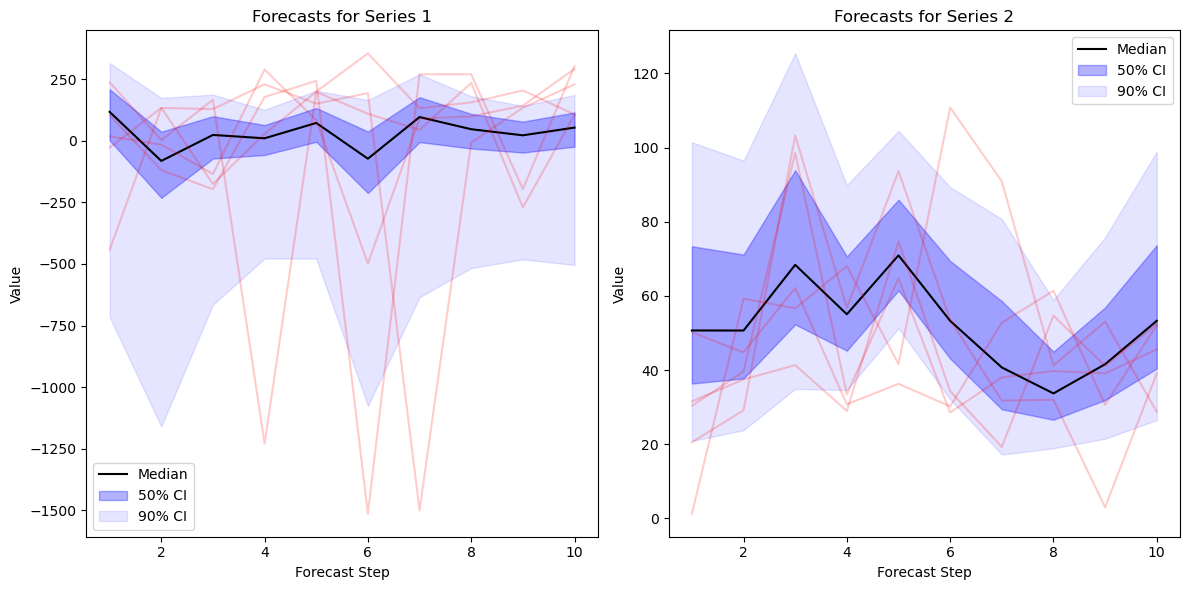

In [41]:
scenario_df, quantile_df = generate_copula_scenarios(
    garch_results_list=[results_up, results_down],
    standardized_residuals_list=[z_up_clean, z_down_clean],
    n_scenarios=1000,
    n_steps=10,
    copula_type="t",  # Use Student's t copula for better tail dependence
    quantiles=[0.05, 0.25, 0.50, 0.75, 0.95]
)

# Print summary statistics
print("Quantile forecast summary:")
print(quantile_df.head())

# Plot the forecasts with quantiles
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(2):  # For each series
    plt.subplot(1, 2, i+1)
    series_name = f"series_{i+1}"
    
    # Plot all quantiles
    plt.plot(quantile_df['step'], quantile_df[f"{series_name}_q50"], 'k-', label='Median')
    plt.fill_between(quantile_df['step'], 
                     quantile_df[f"{series_name}_q25"], 
                     quantile_df[f"{series_name}_q75"],
                     color='blue', alpha=0.3, label='50% CI')
    plt.fill_between(quantile_df['step'], 
                     quantile_df[f"{series_name}_q5"], 
                     quantile_df[f"{series_name}_q95"],
                     color='blue', alpha=0.1, label='90% CI')
    
    # Plot a few individual scenarios for illustration
    for s in range(5):
        scenario_data = scenario_df[scenario_df['scenario'] == s+1]
        plt.plot(scenario_data['step'], scenario_data[series_name], 'r-', alpha=0.2)
    
    plt.title(f"Forecasts for Series {i+1}")
    plt.xlabel("Forecast Step")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()

In [42]:
scenario_df

,step,scenario,series_1,series_2
0,1,1,18.590045,30.338095
1,2,1,-15.433518,39.614624
2,3,1,-134.851774,98.572827
3,4,1,289.614928,33.459118
4,5,1,84.050682,64.749780
...,...,...,...,...
9995,6,1000,-110.263968,5.029550
9996,7,1000,135.297596,41.886018
9997,8,1000,-129.037642,43.816061
9998,9,1000,48.929962,60.693344


In [ ]:
def simulate_residuals_with_copula(standardized_residuals_list, n_scenarios=1000, n_steps=10, copula_type="gaussian"):
    """
    Simulate residuals from multiple time series using a copula to preserve their dependence structure,
    following Patton's methodology (pages 947-949).
    
    Parameters:
    -----------
    standardized_residuals_list : list
        List of arrays containing standardized residuals for each series
    n_scenarios : int
        Number of scenarios to generate
    n_steps : int
        Number of steps to simulate for each scenario
    copula_type : str
        Type of copula to fit ("gaussian" or "t")
    
    Returns:
    --------
    list of numpy arrays
        Each array has shape (n_scenarios, n_steps) and contains simulated residuals
    """
    import numpy as np
    from copulae import GaussianCopula, StudentCopula
    
    n_series = len(standardized_residuals_list)
    
    # Stack residuals for copula fitting
    z_clean = np.column_stack(standardized_residuals_list)
    
    # Fit the specified copula
    if copula_type.lower() == "gaussian":
        cop = GaussianCopula(dim=n_series)
        cop.fit(z_clean)
        print(f"Fitted Gaussian copula with parameters: {cop.params}")
    elif copula_type.lower() == "t":
        cop = StudentCopula(dim=n_series)
        cop.fit(z_clean)
        print(f"Fitted Student's t copula with correlation: {cop.params[0]:.4f} and df: {cop.params[1]:.4f}")
    else:
        raise ValueError("Copula type must be 'gaussian' or 't'")
    
    # Initialize list to store simulated residuals for each series
    simulated_residuals = []
    
    # For each step, draw from the copula and transform to the empirical distribution
    for i in range(n_series):
        # Initialize array for this series
        series_residuals = np.zeros((n_scenarios, n_steps))
        
        # Generate n_scenarios × n_steps random samples from the copula
        for t in range(n_steps):
            u = cop.random(n_scenarios)
            # Transform to standardized residuals using empirical quantile function
            series_residuals[:, t] = np.quantile(standardized_residuals_list[i], u[:, i])
        
        simulated_residuals.append(series_residuals)
    
    return simulated_residuals

In [45]:
def simulate_with_copula_garch(garch_results_list, standardized_residuals_list, 
                              n_scenarios=1000, n_steps=10, 
                              copula_type="gaussian", return_residuals=False):
    """
    Simulate future values using AR-GARCH models with copula-based residuals
    that preserve the dependence structure between series, following Patton's
    methodology (pages 947-949).
    
    Parameters:
    -----------
    garch_results_list : list
        List of fitted GARCH model results objects
    standardized_residuals_list : list
        List of arrays containing standardized residuals for each series
    n_scenarios : int
        Number of scenarios to generate
    n_steps : int
        Number of steps to simulate for each scenario
    copula_type : str
        Type of copula to fit ("gaussian" or "t")
    return_residuals : bool
        Whether to also return the simulated residuals
    
    Returns:
    --------
    list of numpy arrays
        Each array has shape (n_scenarios, n_steps) and contains simulated values
    list of numpy arrays (optional)
        Each array has shape (n_scenarios, n_steps) and contains simulated residuals
    """
    import numpy as np
    from copulae import GaussianCopula, StudentCopula
    
    n_series = len(garch_results_list)
    if n_series != len(standardized_residuals_list):
        raise ValueError("Number of GARCH models must match number of residual series")
    
    # Stack residuals for copula fitting
    z_clean = np.column_stack(standardized_residuals_list)
    
    # Fit the specified copula
    if copula_type.lower() == "gaussian":
        cop = GaussianCopula(dim=n_series)
        cop.fit(z_clean)
    elif copula_type.lower() == "t":
        cop = StudentCopula(dim=n_series)
        cop.fit(z_clean)
    else:
        raise ValueError("Copula type must be 'gaussian' or 't'")
    
    # Initialize arrays to store simulated residuals and forecasts
    simulated_residuals = []
    simulated_forecasts = []
    
    # For each step, draw from the copula and transform to the empirical distribution
    for i in range(n_series):
        # Initialize arrays for this series
        series_residuals = np.zeros((n_scenarios, n_steps))
        series_forecasts = np.zeros((n_scenarios, n_steps))
        
        # Generate n_scenarios × n_steps random samples from the copula
        for t in range(n_steps):
            # Generate random samples from the copula
            u = cop.random(n_scenarios)
            # Transform to standardized residuals using empirical quantile function
            series_residuals[:, t] = np.quantile(standardized_residuals_list[i], u[:, i])
        
        simulated_residuals.append(series_residuals)
        
        # Extract GARCH model for current series
        model = garch_results_list[i]
        
        # For each scenario
        for s in range(n_scenarios):
            # Get the custom residuals for this scenario
            custom_residuals = series_residuals[s]
            
            # Use the forecast method with custom residuals
            sim = model.forecast(horizon=n_steps, method='simulation', 
                                simulations=1, custom_residuals=custom_residuals)
            
            # Extract forecast values
            if hasattr(sim, 'simulations'):
                # ARCH package format
                series_forecasts[s] = sim.simulations.values[-1, :, 0]
            else:
                # Generic fallback - implement manual forecasting if needed
                # Get AR and GARCH parameters
                params = model.params
                
                # Assuming standard AR(1)-GARCH(1,1) structure
                # You'll need to adapt this part based on your model structure
                ar_const = params[0]
                ar_coef = params[1] if len(params) > 1 else 0
                omega = params[-3]
                alpha = params[-2]
                beta = params[-1]
                
                # Initialize
                last_value = model.resid.iloc[-1]
                last_vol = model.conditional_volatility.iloc[-1]
                forecasts = np.zeros(n_steps)
                
                # Generate forecasts
                for t in range(n_steps):
                    # Update volatility
                    if t == 0:
                        vol = np.sqrt(omega + alpha * last_value**2 + beta * last_vol**2)
                    else:
                        vol = np.sqrt(omega + alpha * forecasts[t-1]**2 + beta * vol**2)
                    
                    # Generate AR forecast with shock
                    if t == 0:
                        forecasts[t] = ar_const + ar_coef * last_value + custom_residuals[t] * vol
                    else:
                        forecasts[t] = ar_const + ar_coef * forecasts[t-1] + custom_residuals[t] * vol
                
                series_forecasts[s] = forecasts
        
        simulated_forecasts.append(series_forecasts)
    
    if return_residuals:
        return simulated_forecasts, simulated_residuals
    else:
        return simulated_forecasts

In [46]:
# Assuming results_up and results_down are your fitted GARCH models,
# and z_up_clean and z_down_clean are the standardized residuals

# Generate forecasts with copula-based residuals
simulated_forecasts, simulated_residuals = simulate_with_copula_garch(
    garch_results_list=[results_up, results_down],
    standardized_residuals_list=[z_up_clean, z_down_clean],
    n_scenarios=1000,
    n_steps=10,
    copula_type="t",  # Using Student's t copula for better tail dependence
    return_residuals=True
)

# Extract forecasts for each series
forecasts_up = simulated_forecasts[0]    # Shape: (n_scenarios, n_steps)
forecasts_down = simulated_forecasts[1]  # Shape: (n_scenarios, n_steps)

# Calculate quantiles
import numpy as np
import pandas as pd

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
step_indices = np.arange(1, n_steps+1)
quantile_df = pd.DataFrame({'step': step_indices})

for i, series_name in enumerate(['up', 'down']):
    for q in quantiles:
        q_values = np.quantile(simulated_forecasts[i], q, axis=0)
        quantile_df[f"{series_name}_q{int(q*100)}"] = q_values

print("Forecast quantiles:")
print(quantile_df.head())

# Create scenario dataframe
scenario_df = pd.DataFrame()
scenario_df['step'] = np.tile(np.arange(1, n_steps+1), n_scenarios)
scenario_df['scenario'] = np.repeat(np.arange(1, n_scenarios+1), n_steps)

for i, series_name in enumerate(['up', 'down']):
    flat_forecasts = simulated_forecasts[i].flatten('F')  # Flatten by column
    scenario_df[series_name] = flat_forecasts



TypeError: ARCHModelFixedResult.forecast() got an unexpected keyword argument 'custom_residuals'

In [48]:
def fit_garch_model(residuals, p=1, q=1, lags=1):
    model = arch_model(df['res_up'], mean='AR', lags=2, vol='GARCH', p=1, q=1)
    result = model.fit(disp="on")
    return result

In [ ]:
fit_garch_model()

In [ ]:
def fit_copula_model(residuals_list, copula_type="gaussian"):
    if copula_type.lower() == "gaussian":
        cop = GaussianCopula(dim=len(residuals_list))
    elif copula_type.lower() == "t":
        cop = StudentCopula(dim=len(residuals_list))
    else:
        raise ValueError("Invalid copula type. Choose 'gaussian' or 't'.")
    
    cop.fit(residuals_list)
    return cop

In [ ]:


import numpy as np
import pandas as pd
from arch import arch_model
from copulae import GaussianCopula
import matplotlib.pyplot as plt

# -------------------------
# Load your DataFrame here
# df = pd.read_csv('your_data.csv')
# Ensure it contains columns: SpotPriceEUR, aFRRVWAUpEUR, aFRRVWADownEUR
# -------------------------

# Example dummy data block (remove and replace with your actual df)
# np.random.seed(0)
# dates = pd.date_range("2020-01-01", periods=300)
# df = pd.DataFrame({
#     "SpotPriceEUR": np.random.normal(50, 5, size=300).cumsum(),
#     "aFRRVWAUpEUR": np.random.normal(50, 5, size=300).cumsum(),
#     "aFRRVWADownEUR": np.random.normal(50, 5, size=300).cumsum()
# }, index=dates)

# ----------------------------
# Step 0: Compute residuals
# ----------------------------
df['res_up'] = df['SpotPriceEUR'] - df['aFRRVWAUpEUR']
df['res_down'] = df['SpotPriceEUR'] - df['aFRRVWADownEUR']
df = df.dropna(subset=['res_up', 'res_down'])

last_spot = df['SpotPriceEUR'].iloc[-1]
last_up = df['aFRRVWAUpEUR'].iloc[-1]
last_down = df['aFRRVWADownEUR'].iloc[-1]

# -----------------------------------
# Step 1: Fit AR(10)-GARCH(1,1)
# -----------------------------------
model_up = arch_model(df['res_up'], mean='AR', lags=2, vol='GARCH', p=1, q=1)
model_down = arch_model(df['res_down'], mean='AR', lags=2, vol='GARCH', p=1, q=1)

result_up = model_up.fit(disp="off")
result_down = model_down.fit(disp="off")

# -----------------------------------
# Step 2: Extract standardized residuals
# -----------------------------------
z_up = result_up.resid / result_up.conditional_volatility
z_down = result_down.resid / result_down.conditional_volatility

z_df = pd.DataFrame({'z_up': z_up, 'z_down': z_down}).dropna()
z_vals = z_df.values

# -----------------------------------
# Step 3: Fit Gaussian Copula
# -----------------------------------
cop = GaussianCopula(dim=2)
cop.fit(z_vals)

# -----------------------------------
# Step 4: Simulate standardized residuals
# -----------------------------------
n_scenarios = 100
simulated_z = cop.random(n_scenarios)  # shape (100, 2)

# -----------------------------------
# Step 5: Forecast 1-step volatility & mean
# -----------------------------------
# Volatility
next_vol_up = np.sqrt(result_up.forecast(horizon=1).variance.values[-1, 0])
next_vol_down = np.sqrt(result_down.forecast(horizon=1).variance.values[-1, 0])

# Mean (AR part) using last 10 lags
last_lags_up = df['res_up'].values[-10:][::-1]
last_lags_down = df['res_down'].values[-10:][::-1]

ar_params_up = result_up.params[[f'ar.L{i}' for i in range(1, 11)]].values
ar_params_down = result_down.params[[f'ar.L{i}' for i in range(1, 11)]].values

mean_up = np.dot(ar_params_up, last_lags_up)
mean_down = np.dot(ar_params_down, last_lags_down)

# -----------------------------------
# Step 6: Reconstruct residuals
# -----------------------------------
resid_up_sim = mean_up + simulated_z[:, 0] * next_vol_up
resid_down_sim = mean_down + simulated_z[:, 1] * next_vol_down

# -----------------------------------
# Step 7: Recover implied prices
# -----------------------------------
simulated_up = last_spot - resid_up_sim
simulated_down = last_spot - resid_down_sim

# -----------------------------------
# Step 8: Build output DataFrame
# -----------------------------------
output_df = pd.DataFrame({
    'SpotPrice': [last_spot] * n_scenarios,
    'Last_aFRRVWAUpEUR': [last_up] * n_scenarios,
    'Last_aFRRVWADownEUR': [last_down] * n_scenarios,
    'Scenario_aFRRVWAUpEUR': simulated_up,
    'Scenario_aFRRVWADownEUR': simulated_down
})

print(output_df.head())

# Optional: Plot results
plt.figure(figsize=(10, 5))
plt.hist(output_df['Scenario_aFRRVWAUpEUR'], bins=30, alpha=0.6, label='aFRRVWAUp Simulated')
plt.hist(output_df['Scenario_aFRRVWADownEUR'], bins=30, alpha=0.6, label='aFRRVWADown Simulated')
plt.axvline(last_up, color='blue', linestyle='--', label='Last aFRRVWAUp')
plt.axvline(last_down, color='red', linestyle='--', label='Last aFRRVWADown')
plt.title("Simulated Forecast Scenarios")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.784e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.185e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


KeyError: "None of [Index(['ar.L1', 'ar.L2', 'ar.L3', 'ar.L4', 'ar.L5', 'ar.L6', 'ar.L7', 'ar.L8',\n       'ar.L9', 'ar.L10'],\n      dtype='object')] are in the [index]"